In [39]:
import numpy as np 
import pandas as pd 

import math 
from datetime import date, timedelta, datetime 
import time
import os

from pandas.plotting import register_matplotlib_converters 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 
import seaborn as sns

from sklearn.preprocessing import  MinMaxScaler 

from sklearn.metrics import mean_absolute_error, mean_squared_error 

import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM, Dense, Dropout 
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras import backend

from tensorflow.keras.models import load_model
import joblib

import keras_tuner as kt
from keras_tuner.engine.hyperparameters import HyperParameters


from google.cloud import bigquery
from google.oauth2 import service_account

  
print('Tensorflow Version: ' + tf.__version__)


Tensorflow Version: 2.11.1


# Reference Document

* [https://www.relataly.com/stock-price-prediction-multi-output-regression-using-neural-networks-in-python/5800/](https://www.relataly.com/stock-price-prediction-multi-output-regression-using-neural-networks-in-python/5800/)
* [https://www.relataly.com/univariate-stock-market-forecasting-using-a-recurrent-neural-network/122/](https://www.relataly.com/univariate-stock-market-forecasting-using-a-recurrent-neural-network/122/)
* [https://www.relataly.com/stock-market-prediction-using-multivariate-time-series-in-python/1815/](https://www.relataly.com/stock-market-prediction-using-multivariate-time-series-in-python/1815/)
* [https://www.relataly.com/regression-error-metrics-python/923/](https://www.relataly.com/regression-error-metrics-python/923/)
* [https://keras.io/guides/keras_tuner/getting_started/](https://keras.io/guides/keras_tuner/getting_started/)
* [https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/](https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/)
* [http://colah.github.io/posts/2015-08-Understanding-LSTMs/](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)

In [40]:
start_date='2015-01-01' 
end_date='2023-05-31'
asset_name='QQQ'   

# univaiate  (single feature)
# prediction_col='EMA1'
# feature_cols=['EMA1']

# multpvaric (nultiple features)
prediction_col='Close'
feature_cols=[prediction_col,'EMA1','EMA2','MACD','SIGNAL']

# Load the Data from  BigQuery To Create TrainData as CSV File 

In [41]:
projectId="pongthorn"
dataset_id='FinAssetForecast'
table_data_id=f"{projectId}.{dataset_id}.fin_data"
print(table_data_id)

client = bigquery.Client(project=projectId )

def load_data_bq(sql:str):
 query_result=client.query(sql)
 df=query_result.to_dataframe()
 return df

data_path=f"train_data/{asset_name}_{start_date.replace('-','')}_{end_date.replace('-','')}.csv"

if  os.path.exists(data_path)==False:
    sqlData=f"""
     select * from  `{table_data_id}` where Symbol='{asset_name}' and (Date>='{start_date}' and Date<='{end_date}')
    """
    print(sqlData)
    df=load_data_bq(sqlData)
    df=df.sort_values(by="Date")
    df=df.drop_duplicates(subset=['Date','Symbol'],keep='last')
    df=df.drop(columns=['ImportDateTime'])
    df.to_csv(data_path,index=False)
    print(df.info())
    print("Load Data from BigQuery and Save it as csv.")
else:
    print(f"Load csv {data_path}")

pongthorn.FinAssetForecast.fin_data
Load csv train_data/QQQ_20150101_20230531.csv


# Init Constant Variable

In [42]:
date_col='Date'

# feature_cols=['Close','EMA1','SIGNAL','RSI']

main_obj_metric='mean_absolute_error'
main_loss='mean_absolute_error'


input_sequence_length =30  #60 #120
output_sequence_length =5  # 10 #20
train_ratio=0.8

n_epochs =25  #50 #100/150/200
n_batch_size = 32  # 32/48/64

n_early=11

seed=88

#Tuning
mx_step=4  # 2,3,5,10
mxMultipleStep=1
nExecutions_per_trial=3 #3  #averger re-run on 1 trail 

min_drop=0.0
max_drop=  0.2 #0.1 0.2  0.5
step_drop=0.1

defaultMaxTrail=10

ratio_traial_max= 1 #0.5 0.7/0.8/1


# Set Tuned-Model Folder

In [43]:
model_path='train_model'
period_str=f"Y{start_date.split('-')[0]}-{end_date.split('-')[0]}"
tune_folder=f'{prediction_col}_{input_sequence_length}To{output_sequence_length}_{asset_name}_E{n_epochs}S{n_early}'
print(tune_folder)

Close_30To5_QQQ_E25S11


# Read Train Data

In [44]:
df=pd.read_csv(data_path)
df.drop(columns=['Symbol'],inplace=True)

print(df.tail(input_sequence_length+output_sequence_length+2).reset_index(drop=True)[feature_cols])

df.set_index(date_col,inplace=True)
df=df[feature_cols]
print(df.info())

allCols=list(df.columns)
print(allCols)



     Close      EMA1      EMA2    MACD  SIGNAL
0   317.87  315.4643  311.1299  4.3344  3.5866
1   315.83  315.5308  311.5776  3.9533  3.6324
2   313.04  315.0780  311.7168  3.3611  3.5985
3   319.17  315.8220  312.4267  3.3953  3.5731
4   318.57  316.3216  313.0117  3.3099  3.5402
5   318.84  316.7795  313.5668  3.2127  3.4993
6   318.86  317.1578  314.0709  3.0868  3.4477
7   318.71  317.4400  314.5127  2.9273  3.3827
8   316.28  317.2291  314.6811  2.5480  3.2783
9   316.61  317.1165  314.8648  2.2518  3.1500
10  315.95  316.9044  314.9681  1.9363  2.9983
11  309.99  315.6473  314.4940  1.1532  2.7677
12  311.87  314.9605  314.2441  0.7164  2.5113
13  320.35  315.9404  314.8256  1.1148  2.3367
14  322.56  317.1440  315.5622  1.5817  2.2423
15  322.19  318.0614  316.1934  1.8680  2.1955
16  319.38  318.3012  316.4969  1.8042  2.1466
17  317.29  318.1173  316.5725  1.5449  2.0714
18  316.17  317.7633  316.5341  1.2291  1.9661
19  322.89  318.6954  317.1394  1.5559  1.9148
20  323.69  3

In [45]:
print("split dataframe to show data is the time-dependent ( squecail sample data point)")
_dfTrain=df.loc['2015-01-01':'2021-12-31',:]
print(_dfTrain.shape)  
print(_dfTrain.head())
print(_dfTrain.tail())

print("=========================================================")

_dfTest=df.loc['2022':,:]
print(_dfTest.shape)  
print(_dfTest.head())
print(_dfTest.tail())

split dataframe to show data is the time-dependent ( squecail sample data point)
(1763, 5)
             Close      EMA1      EMA2    MACD  SIGNAL
Date                                                  
2015-01-02  102.94  103.8389  103.9428 -0.1040 -0.1462
2015-01-05  101.43  103.4009  103.7035 -0.3026 -0.1658
2015-01-06  100.07  102.7953  103.3575 -0.5622 -0.2153
2015-01-07  101.36  102.5343  103.1672 -0.6329 -0.2675
2015-01-08  103.30  102.6735  103.1799 -0.5063 -0.2974
             Close      EMA1      EMA2    MACD  SIGNAL
Date                                                  
2021-12-27  403.48  393.5140  392.6328  0.8813  0.2760
2021-12-28  401.61  394.9860  393.4877  1.4983  0.4288
2021-12-29  401.55  396.1795  394.2556  1.9239  0.6157
2021-12-30  400.35  396.9378  394.8360  2.1018  0.8014
2021-12-31  397.85  397.1036  395.1230  1.9806  0.9488
(354, 5)
             Close      EMA1      EMA2    MACD  SIGNAL
Date                                                  
2022-01-03  401.68  

# Exploring the Data

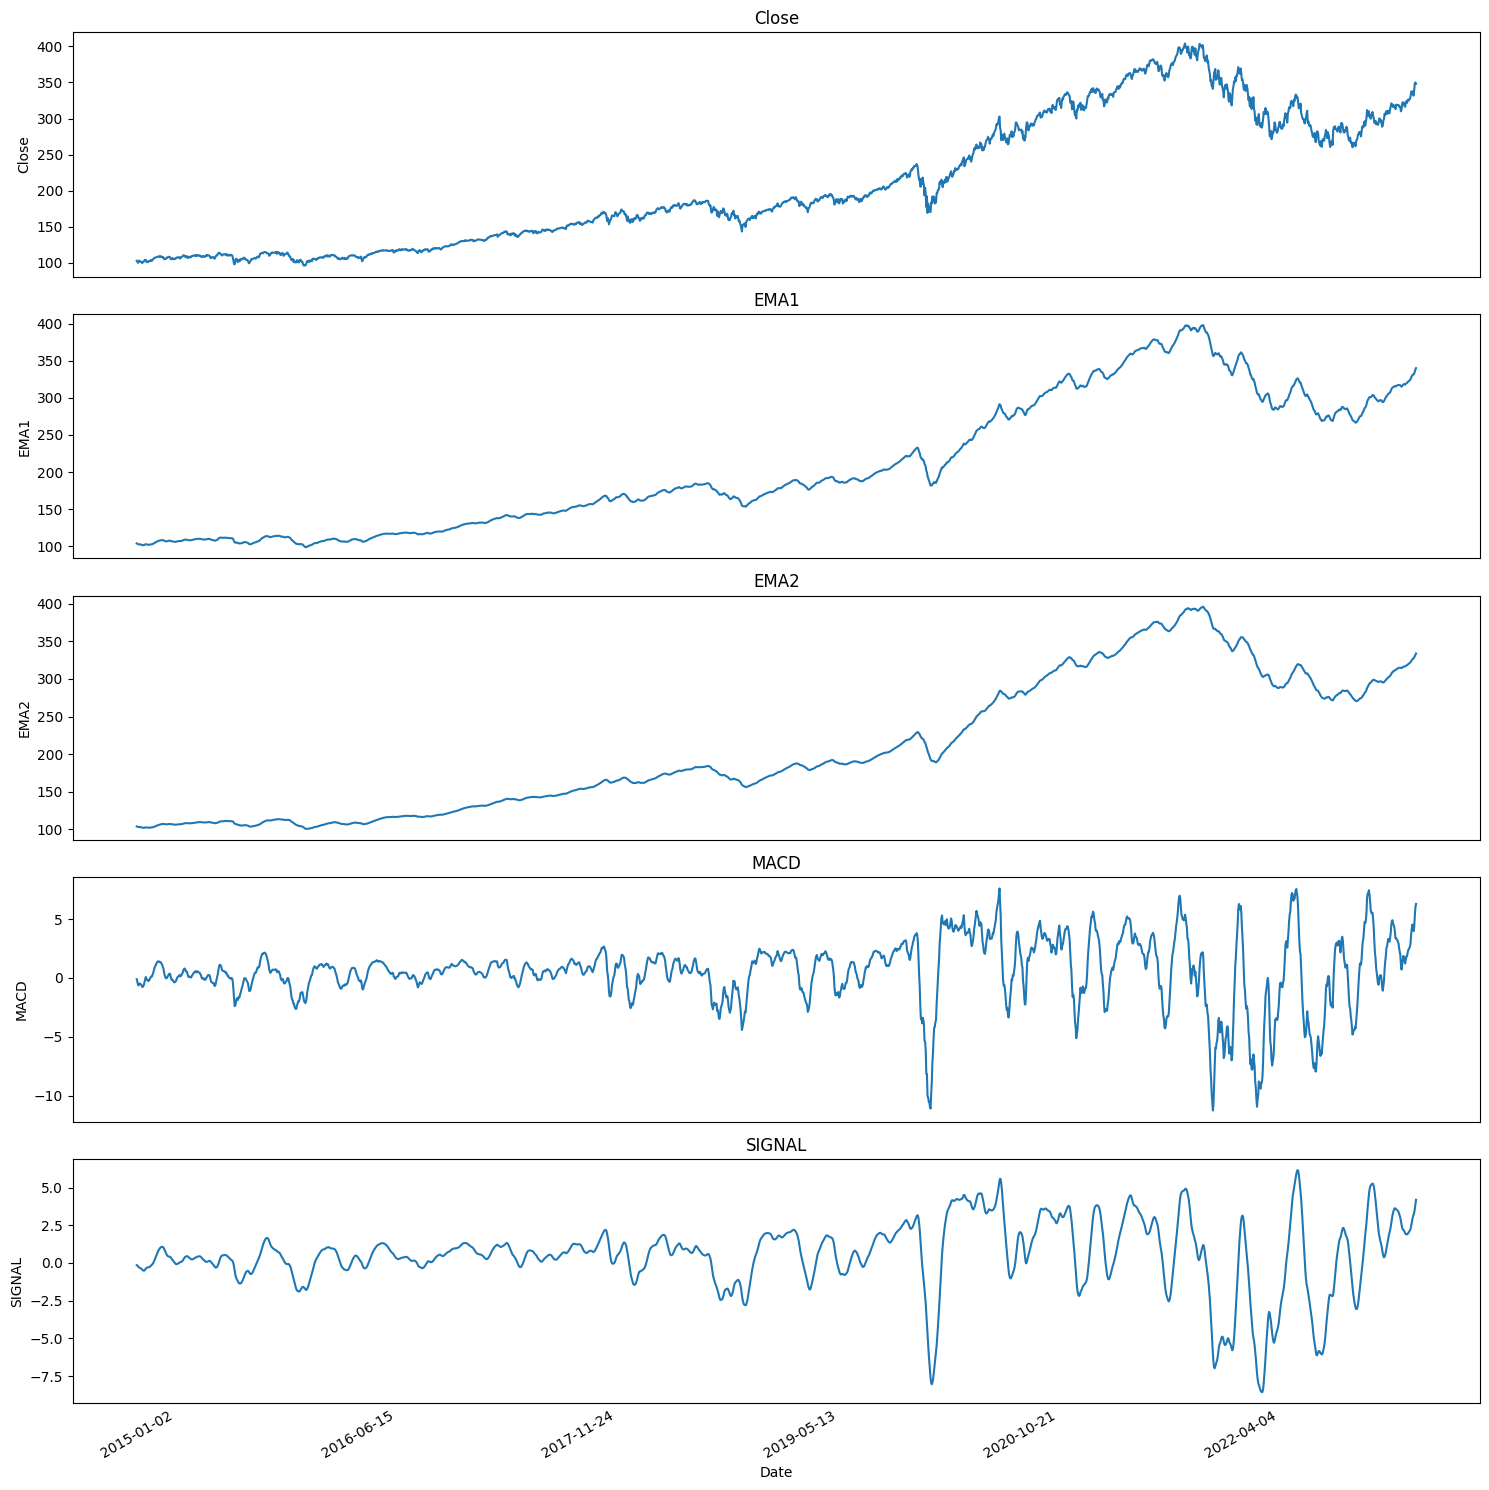

In [46]:
ncols = 1
nrows = len(feature_cols)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(15, 15))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.title.set_text(df.columns[i])
fig.tight_layout()
plt.show()

# Get Data Proper To Train Model

In [47]:
def prepare_data(df):

    print("Convert the data to numpy arrays value")
    np_feature_unscaled = np.array(df)
    np_feature_unscaled = np.reshape(np_feature_unscaled, (df.shape[0], -1))
    print(np_feature_unscaled.shape)
    
    np_pred_unscaled = np.array(df[prediction_col]).reshape(-1, 1)
    print(np_pred_unscaled.shape)
    
    return np_feature_unscaled, np_pred_unscaled

np_feature_unscaled, np_pred_unscaled = prepare_data(df)   


print("Feature Data",np_feature_unscaled.shape)
print(np_feature_unscaled[:3])
print("Prediction Data",np_pred_unscaled.shape)
print(np_pred_unscaled[:3])

Convert the data to numpy arrays value
(2117, 5)
(2117, 1)
Feature Data (2117, 5)
[[102.94   103.8389 103.9428  -0.104   -0.1462]
 [101.43   103.4009 103.7035  -0.3026  -0.1658]
 [100.07   102.7953 103.3575  -0.5622  -0.2153]]
Prediction Data (2117, 1)
[[102.94]
 [101.43]
 [100.07]]


In [48]:
print(f"{input_sequence_length} = How far back the model looks back during training to forecast).")
print(f"{output_sequence_length} = How far into the future the model forecasts the target value")

#How much ratio to split
index_Prediction = df.columns.get_loc(prediction_col)
print(f"Prediction Index = {index_Prediction}")



30 = How far back the model looks back during training to forecast).
5 = How far into the future the model forecasts the target value
Prediction Index = 0


In [49]:
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_length = math.ceil(np_feature_unscaled.shape[0] * train_ratio)
print(f"{train_ratio} = {train_data_length} Split the training data into train and train data sets")

0.8 = 1694 Split the training data into train and train data sets


In [56]:
print("Scale feature and prediction to a range Max-Min between 0 and 1")
scaler_train = MinMaxScaler()
scaler_pred = MinMaxScaler()


print("Split data and apply only train to scale")

train_data = np_feature_unscaled[0:train_data_length, :]
test_data = np_feature_unscaled[train_data_length - input_sequence_length:, :]

np_PredictVal_unScaled=np_pred_unscaled[0:train_data_length]

print("Train Data to be scaled(feature and prediction)") 
print(train_data.shape,np_PredictVal_unScaled.shape)
print(train_data[:5])
print(np_PredictVal_unScaled[:5])

train_data=scaler_train.fit_transform(train_data)
test_data=scaler_train.transform(test_data)

print(f"For predict test that take the past {input_sequence_length} train value to predict the first test value")
np_scaled=scaler_train.transform(np_feature_unscaled)
np_scaled_prediction = scaler_pred.fit_transform(np_PredictVal_unScaled)

print("==============Scaler Object For Features=================")  
print(f"{scaler_train.n_features_in_} features are scaled in range 0-1 such as {feature_cols}")
print(f"Max:{scaler_train.data_max_} -  Min:{scaler_train.data_min_}")

print("==============Scaler Object For Prediction Target Value=================")  
print(f"{scaler_pred.n_features_in_} pred col is scaled in range 0-1 such as {prediction_col}")
print(f"Max:{scaler_pred.data_max_} -  Min:{scaler_pred.data_min_}")


print("=========================================")       
print("Scaled data completely")
print("Scaled train and test data")
print(train_data.shape,test_data.shape)
print(train_data[:5])
print(test_data[:5])

print("=========================================")  
print("Scale Prediction data (Scaled from Train data)")
print(np_scaled_prediction.shape)
print(np_scaled_prediction[:5])



Scale feature and prediction to a range Max-Min between 0 and 1
Split data and apply only train to scale
Train Data to be scaled(feature and prediction)
(1694, 5) (1694, 1)
[[102.94   103.8389 103.9428  -0.104   -0.1462]
 [101.43   103.4009 103.7035  -0.3026  -0.1658]
 [100.07   102.7953 103.3575  -0.5622  -0.2153]
 [101.36   102.5343 103.1672  -0.6329  -0.2675]
 [103.3    102.6735 103.1799  -0.5063  -0.2974]]
[[102.94]
 [101.43]
 [100.07]
 [101.36]
 [103.3 ]]
For predict test that take the past 30 train value to predict the first test value
==============Scaler Object For Features=================
5 features are scaled in range 0-1 such as ['Close', 'EMA1', 'EMA2', 'MACD', 'SIGNAL']
Max:[382.11   378.776  376.0118   7.6042   5.5866] -  Min:[ 96.32    98.7107 100.6653 -11.0952  -8.0469]
==============Scaler Object For Prediction Target Value=================
1 pred col is scaled in range 0-1 such as Close
Max:[382.11] -  Min:[96.32]
Scaled data completely
Scaled train and test data
(16

==============Scaler Object For Features=================
5 features are scaled in range 0-1 such as ['Close', 'EMA1', 'EMA2', 'MACD', 'SIGNAL']
Max:[382.11   378.776  376.0118   7.6042   5.5866] -  Min:[ 96.32    98.7107 100.6653 -11.0952  -8.0469]
==============Scaler Object For Prediction Target Value=================
1 pred col is scaled in range 0-1 such as Close
Max:[382.11] -  Min:[96.32]


In [52]:
print("The LSTM RNN needs data with the format of [sample rows, time steps, features]")
def partition_dataset(input_sequence_length, output_sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(input_sequence_length, data_len - output_sequence_length):
        x.append(data[i-input_sequence_length:i,:])
        y.append(data[i:i + output_sequence_length, index_Prediction]) 
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

The LSTM RNN needs data with the format of [sample rows, time steps, features]


In [53]:
print(f"Here, we create {len(train_data)} samples, input_sequence_length time steps per sample, and features")

print("Generate training data and test data")
x_train, y_train = partition_dataset(input_sequence_length, output_sequence_length, train_data)
x_test, y_test = partition_dataset(input_sequence_length, output_sequence_length, test_data)

print("The shapes: the result is: (rows, training_sequence, features) (prediction value, )")
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

print(f"Use {prediction_col} samples over the past {input_sequence_length} days to predict the future over the next {output_sequence_length} days")
print(x_train[-1:],y_train[-1:])

Here, we create 1694 samples, input_sequence_length time steps per sample, and features
Generate training data and test data
The shapes: the result is: (rows, training_sequence, features) (prediction value, )
(1659, 30, 1) (1659, 5)
(418, 30, 1) (418, 5)
Use EMA1 samples over the past 30 days to predict the future over the next 5 days
[[[0.9514656 ]
  [0.9543785 ]
  [0.95570997]
  [0.95724104]
  [0.95726639]
  [0.95687827]
  [0.95741779]
  [0.95869642]
  [0.95984686]
  [0.95867785]
  [0.95543646]
  [0.95392039]
  [0.95512725]
  [0.95968547]
  [0.96415515]
  [0.96809101]
  [0.96976634]
  [0.97348725]
  [0.97927126]
  [0.98380235]
  [0.98791853]
  [0.9911692 ]
  [0.99458876]
  [0.99773696]
  [0.99944941]
  [1.        ]
  [0.99858105]
  [0.997251  ]
  [0.9954682 ]
  [0.99582097]]] [[0.99627837 0.99374396 0.98639246 0.98066987 0.97820794]]


# Model Training

# Paramterter Network

In [54]:
# Configure the neural network model
# tf.random.set_seed(7)
print("Keras Tuning Parameter Setting")

model = Sequential()
n_output_neurons = output_sequence_length
  
inputshape_Timestamps= x_train.shape[1]
no_feature=x_train.shape[2]
neuron_number =inputshape_Timestamps * no_feature


step_neuron=int(neuron_number)
max_neuron=int(step_neuron*mx_step)
print(f"Train Row : {x_train.shape[0]} to predict future {n_output_neurons}")
print(f"Total NN : {neuron_number}= {inputshape_Timestamps}(backward step) x {no_feature} (features) with Hidden Node Unit from {step_neuron} to {max_neuron}")
    


neuron_list = [*range(neuron_number, max_neuron+step_neuron, step_neuron)]

drop_list=np.arange (min_drop, max_drop ,step_drop)
drop_list=np.append(drop_list,[max_drop])

allPosComb=len(neuron_list)*len(drop_list)
print(f"{neuron_list} and {drop_list}")
print(f"all combination : {len(neuron_list)} x {len(drop_list)} = {allPosComb}")

nMax_trials=math.ceil(allPosComb*ratio_traial_max)
nMax_trials=nMax_trials*mxMultipleStep

if nMax_trials<defaultMaxTrail: 
    nMax_trials=defaultMaxTrail

nMax_trials=nMax_trials*1
print("MAx run :" ,nMax_trials , "each trail run to essemble ",nExecutions_per_trial)

Keras Tuning Parameter Setting
Train Row : 1659 to predict future 5
Total NN : 30= 30(backward step) x 1 (features) with Hidden Node Unit from 30 to 120
[30, 60, 90, 120] and [0.  0.1 0.2]
all combination : 4 x 3 = 12
MAx run : 12 each trail run to essemble  3


# NetWork Architeture Model Design

In [46]:
def build_model_way(hp):
    
    model = Sequential()

    model.add(LSTM( hp.Int('input_unit',min_value=neuron_number ,max_value=max_neuron,step=step_neuron) \
                   , return_sequences=False, input_shape=(inputshape_Timestamps,no_feature)))
    
    model.add(Dropout(hp.Float('Dropout_rate',min_value=min_drop,max_value=max_drop,step=step_drop))) 
    
    model.add(Dense(n_output_neurons))

    model.compile(optimizer="adam", loss=main_loss, metrics=[main_obj_metric])
    return model

# Start Tuning 

In [47]:
buildtime = datetime.now().strftime('%d%m%y_%H%M')
project_model=f"{tune_folder}_{buildtime}"
print(project_model)


t_Start=time.time()

print(f"Start tund at {datetime.now()}")

Close_30To5_QQQ_E25S11_140623_0051
Start tund at 2023-06-14 00:51:17.475663


In [48]:
early_stop = EarlyStopping(monitor='val_loss', patience=n_early, verbose=1)

tuner = kt.BayesianOptimization(
# tuner = kt.Hyperband(
# tuner= kt.RandomSearch(
        build_model_way,
        objective=main_obj_metric,
        max_trials=nMax_trials,
        seed=seed,
        executions_per_trial=nExecutions_per_trial,
        directory=f"tuning/{tune_folder}/",
        project_name= project_model
   
        )
tuner.search(x_train, y_train, batch_size=n_batch_size, epochs=n_epochs,
                        validation_data=(x_test, y_test),
                        shuffle=False,verbose=1,callbacks=[early_stop])



Trial 3 Complete [00h 03m 08s]
mean_absolute_error: 0.05221203217903773

Best mean_absolute_error So Far: 0.044546253979206085
Total elapsed time: 00h 05m 22s
INFO:tensorflow:Oracle triggered exit


In [49]:
print("Space to search")
tuner.search_space_summary()
print(f"Suumary of {nMax_trials}")
tuner.results_summary()

Space to search
Search space summary
Default search space size: 2
input_unit (Int)
{'default': None, 'conditions': [], 'min_value': 150, 'max_value': 300, 'step': 150, 'sampling': 'linear'}
Dropout_rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.2, 'step': 0.1, 'sampling': 'linear'}
Suumary of 3
Results summary
Results in tuning/Close_30To5_QQQ_E25S11/Close_30To5_QQQ_E25S11_140623_0051
Showing 10 best trials
Objective(name="mean_absolute_error", direction="min")

Trial 0 summary
Hyperparameters:
input_unit: 150
Dropout_rate: 0.0
Score: 0.044546253979206085

Trial 2 summary
Hyperparameters:
input_unit: 300
Dropout_rate: 0.2
Score: 0.05221203217903773

Trial 1 summary
Hyperparameters:
input_unit: 150
Dropout_rate: 0.2
Score: 0.055149694283803306


In [50]:
t_End=time.time()
t_elapsed=(t_End-t_Start)/60/60
print('Total execution : ',round(t_elapsed,2)) 
print(datetime.now())

Total execution :  0.09
2023-06-14 00:56:40.431097


# Get Optimal HyperParamters

In [52]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)
print("build model from  the best tuning")

# model=tuner.get_best_models(num_models=1)[0]

model = tuner.hypermodel.build(best_hps)
print(model.summary())

{'input_unit': 150, 'Dropout_rate': 0.0}
build model from  the best tuning
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 150)               93600     
                                                                 
 dropout_1 (Dropout)         (None, 150)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 755       
                                                                 
Total params: 94,355
Trainable params: 94,355
Non-trainable params: 0
_________________________________________________________________
None


# Training the TUNED Model 

In [53]:
print(f"Training the Best Model")
t_Start=time.time()
print(datetime.now())


early_stop = EarlyStopping(monitor='val_loss', patience=n_early, verbose=1)
history = model.fit(x_train, y_train, 
                batch_size=n_batch_size, 
                epochs=n_epochs,
                shuffle=False,
                validation_data=(x_test, y_test),
                verbose=2, callbacks=[early_stop]
               )
        
t_End=time.time()
t_elapsed=(t_End-t_Start)/60/60
print('Total execute making report : ',round(t_elapsed,2)) 
print(datetime.now())

Training the Best Model
2023-06-14 00:57:48.007391
Epoch 1/25
21/21 - 3s - loss: 0.0944 - mean_absolute_error: 0.0944 - val_loss: 0.0790 - val_mean_absolute_error: 0.0790 - 3s/epoch - 139ms/step
Epoch 2/25
21/21 - 0s - loss: 0.2332 - mean_absolute_error: 0.2332 - val_loss: 0.1473 - val_mean_absolute_error: 0.1473 - 481ms/epoch - 23ms/step
Epoch 3/25
21/21 - 0s - loss: 0.1564 - mean_absolute_error: 0.1564 - val_loss: 0.1290 - val_mean_absolute_error: 0.1290 - 477ms/epoch - 23ms/step
Epoch 4/25
21/21 - 0s - loss: 0.0920 - mean_absolute_error: 0.0920 - val_loss: 0.0582 - val_mean_absolute_error: 0.0582 - 483ms/epoch - 23ms/step
Epoch 5/25
21/21 - 0s - loss: 0.0991 - mean_absolute_error: 0.0991 - val_loss: 0.1259 - val_mean_absolute_error: 0.1259 - 490ms/epoch - 23ms/step
Epoch 6/25
21/21 - 0s - loss: 0.1175 - mean_absolute_error: 0.1175 - val_loss: 0.0839 - val_mean_absolute_error: 0.0839 - 485ms/epoch - 23ms/step
Epoch 7/25
21/21 - 0s - loss: 0.0619 - mean_absolute_error: 0.0619 - val_lo

In [54]:
val_per_epoch = history.history[main_obj_metric]
best_epoch = len(val_per_epoch) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 26


In [55]:
print("List Metrics")
for key in history.history.keys():
    print(key)
print("=====================================================")    
# Evaluate the model on the test data using `evaluate`
#https://www.tensorflow.org/guide/keras/train_and_evaluate
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=n_batch_size)
print("test loss, test acc:", results)

List Metrics
loss
mean_absolute_error
val_loss
val_mean_absolute_error
Evaluate on test data
6/6 [==============================] - 0s 8ms/step - loss: 0.0429 - mean_absolute_error: 0.0429
test loss, test acc: [0.04289212450385094, 0.04289212450385094]


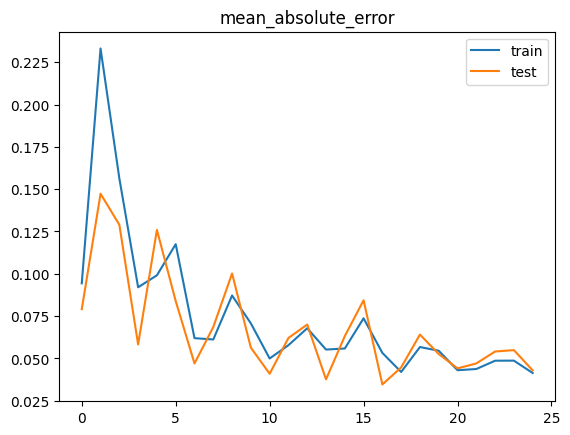

In [56]:
plt.title(main_obj_metric)
plt.plot(history.history[main_obj_metric], label='train')
plt.plot(history.history[f'val_{main_obj_metric}'], label='test')
plt.legend()
plt.show()

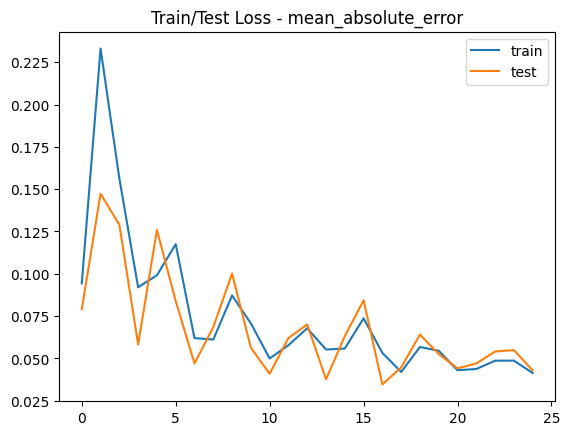

In [57]:
plt.title(f"Train/Test Loss - {main_loss}")
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# Step #5 Evaluate Model Performance

In [58]:
# Get the predicted values
y_pred_scaled = model.predict(x_test)
print(y_pred_scaled.shape)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test).reshape(-1, output_sequence_length)
print(y_pred.shape)
print(y_test_unscaled.shape)

6/6 [==============================] - 0s 8ms/step
(166, 5)
(166, 5)
(166, 5)


In [59]:
# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Mean Absolute Error (MAE): {np.round(MAE, 2)}')
print("===========================================================================")

MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')


# Root Mean  Squre Error
RMSE = math.sqrt( mean_squared_error(y_test_unscaled, y_pred))
print(f'Root MEAN Square Error(RMSE): {np.round(RMSE, 2)}')




Mean Absolute Error (MAE): 10.07
Root MEAN Square Error(RMSE): 11.99
Mean Absolute Percentage Error (MAPE): 3.47 %
Median Absolute Percentage Error (MDAPE): 3.16 %


# Plot Multiple Forcast (Most Complex Step)

In [60]:
def prepare_df(i, x, y, y_pred_unscaled):
    # Undo the scaling on x, reshape the testset into a one-dimensional array, so that it fits to the pred scaler
    x_test_unscaled_df = pd.DataFrame(scaler_pred.inverse_transform((x[i]))[:,index_Prediction])\
    .rename(columns={0:'x_test'})
    
    y_test_unscaled_df = []
    # Undo the scaling on y
    if type(y) == np.ndarray:
        y_test_unscaled_df = pd.DataFrame(scaler_pred.inverse_transform(y)[i]).rename(columns={0:'y_test'})

    # Create a dataframe for the y_pred at position i, y_pred is already unscaled
    y_pred_df = pd.DataFrame(y_pred_unscaled[i]).rename(columns={0:'y_pred'})
    return x_test_unscaled_df, y_pred_df, y_test_unscaled_df


def plot_multi_test_forecast(x_test_unscaled_df, y_test_unscaled_df, y_pred_df, title): 
    # Package y_pred_unscaled and y_test_unscaled into a dataframe with columns pred and true   
    if type(y_test_unscaled_df) == pd.core.frame.DataFrame:
        df_merge = y_pred_df.join(y_test_unscaled_df, how='left')
    else:
        df_merge = y_pred_df.copy()
    
    # Merge the dataframes 
    df_merge_ = pd.concat([x_test_unscaled_df, df_merge]).reset_index(drop=True)
    
    # Plot the linecharts
    fig, ax = plt.subplots(figsize=(20, 8))
    plt.title(title, fontsize=12)
    ax.set(ylabel = f"{asset_name}-{prediction_col}")
    sns.lineplot(data = df_merge_, linewidth=2.0, ax=ax)



# Step #6 Create a new Forecast

In [61]:
x_test_latest_batch = np_scaled[-(input_sequence_length+1):-1,:].reshape(1,input_sequence_length,len(feature_cols))
print(f"{x_test_latest_batch.shape} is the latest input batch from the test dataset, which is contains the price values for the last {input_sequence_length} trading days")

x_test_latest_batch

(1, 30, 5) is the latest input batch from the test dataset, which is contains the price values for the last 30 trading days


array([[[0.63726618, 0.6264471 , 0.60491699, 0.76054068, 0.8158972 ],
        [0.63662704, 0.62775212, 0.60705225, 0.75208587, 0.8114847 ],
        [0.62627296, 0.62677683, 0.60786615, 0.73197986, 0.80439756],
        [0.62767907, 0.62625611, 0.60875399, 0.71627882, 0.79568798],
        [0.62486685, 0.62527527, 0.60925324, 0.69955473, 0.78538989],
        [0.59947164, 0.61946188, 0.60696188, 0.658044  , 0.76973573],
        [0.60748221, 0.61628581, 0.60575409, 0.63489001, 0.75233014],
        [0.64361498, 0.62081731, 0.60856453, 0.65600848, 0.7404775 ],
        [0.65303166, 0.62638329, 0.61212458, 0.68075802, 0.7340692 ],
        [0.65145511, 0.63062575, 0.61517523, 0.69593427, 0.73089221],
        [0.63948187, 0.63173469, 0.61664207, 0.69255235, 0.72757265],
        [0.63057651, 0.63088426, 0.61700746, 0.67880732, 0.72246774],
        [0.62580425, 0.62924721, 0.61682187, 0.66206732, 0.7153195 ],
        [0.65443777, 0.63355765, 0.61974734, 0.67939041, 0.71183702],
        [0.65784652,

In [62]:
y_pred_scaled = model.predict(x_test_latest_batch)
y_pred_unscaled = scaler_pred.inverse_transform(y_pred_scaled)
print(f"Predict on the inverse transformed batch {y_pred_unscaled.shape}")
print(y_pred_unscaled)

1/1 [==============================] - 0s 26ms/step
Predict on the inverse transformed batch (1, 5)
[[358.8781  359.39203 356.12018 354.53482 347.4982 ]]


In [63]:
print("Prepare the data and plot the input data and the predictions")
x_test_unscaled_df, y_test_unscaled_df, _ = prepare_df(0, x_test_latest_batch, '', y_pred_unscaled)
print(f"X-Test= {x_test_unscaled_df.shape}")
print(f"Y-Test= {y_test_unscaled_df.shape}")

# print(x_test_unscaled_df.tail(len(y_test_unscaled_df)))
# print(y_test_unscaled_df.tail(len(y_test_unscaled_df)))

Prepare the data and plot the input data and the predictions
X-Test= (30, 1)
Y-Test= (5, 1)


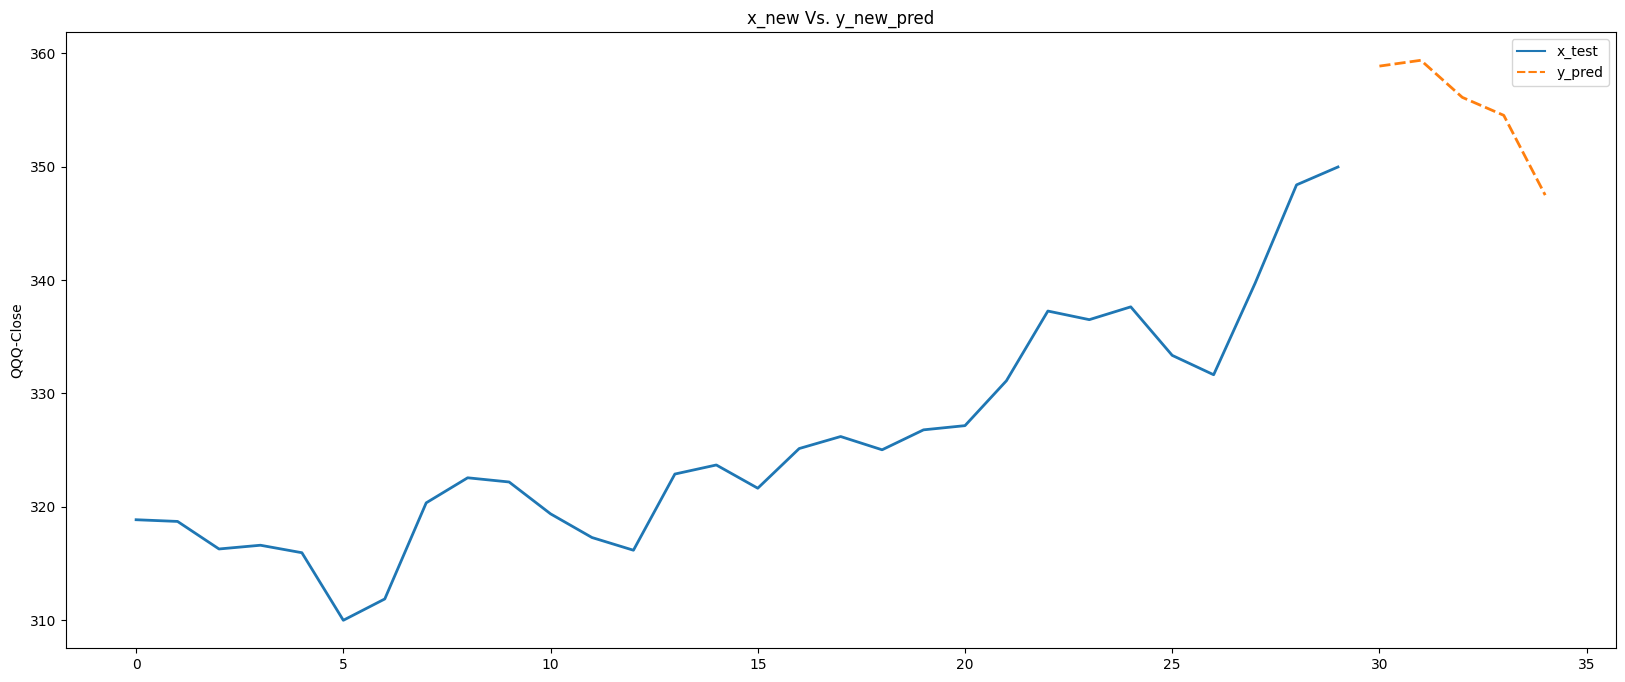

In [64]:
plot_multi_test_forecast(x_test_unscaled_df, '',y_test_unscaled_df, "x_new Vs. y_new_pred")

# Save Tuned Model

In [65]:
print("Save tune-best-model and scaler")
modelName=f"best_tune_{tune_folder}-{period_str}"

file_model=f'{model_path}/{modelName}.h5'
file_scaler=f'{model_path}/scaler_{modelName}.gz'
file_scaler_pred=f'{model_path}/scaler_pred_{modelName}.gz'

model.save(file_model)
joblib.dump(scaler_train,file_scaler)
joblib.dump(scaler_pred,file_scaler_pred)

Save tune-best-model and scaler


['train_model/scaler_pred_best_tune_Close_30To5_QQQ_E25S11-Y2020-2023.gz']

#### 

# Create Final Model

In [66]:
dfAll=df.sort_values(by=[date_col]).copy()
npAll_unscaled, npPredictCol_unscaled = prepare_data(dfAll) 
print(npAll_unscaled.shape,npPredictCol_unscaled.shape)

Convert the data to numpy values
(859, 5)
(859, 1)
(859, 5) (859, 1)


In [67]:
scalerFinalTrain = MinMaxScaler()
scalerFinalPred = MinMaxScaler()
npAll_scaled = scalerFinalTrain.fit_transform(npAll_unscaled)
npAllPredictCol_scaled = scalerFinalPred.fit_transform(npPredictCol_unscaled)
print(npAll_scaled.shape,npAllPredictCol_scaled.shape)
print(npAll_scaled[:2])
print(npAllPredictCol_scaled[:2])

(859, 5) (859, 1)
[[0.19966765 0.14140256 0.10091689 0.72842301 0.72398835]
 [0.19123099 0.1430077  0.1029376  0.72466472 0.72666979]]
[[0.19966765]
 [0.19123099]]


In [68]:
x_all, y_all = partition_dataset(input_sequence_length, output_sequence_length,npAll_scaled)
print(f"We will tranin {x_all.shape},{y_all.shape} with batch={n_batch_size} and best epoch={best_epoch}")

We will tranin (824, 30, 5),(824, 5) with batch=32 and best epoch=26


In [69]:
print(f"Training All")
t_Start=time.time()
print(datetime.now())

history_final=model.fit(x=x_all, y=y_all, batch_size=n_batch_size, epochs=best_epoch,shuffle=False)
        
t_End=time.time()
t_elapsed=(t_End-t_Start)/60/60
print('Total execute making report : ',round(t_elapsed,2)) 
print(datetime.now())

Training All
2023-06-14 01:00:11.570807
Epoch 1/26
26/26 [==============================] - 1s 28ms/step - loss: 0.0387 - mean_absolute_error: 0.0387
Epoch 2/26
26/26 [==============================] - 1s 27ms/step - loss: 0.0402 - mean_absolute_error: 0.0402
Epoch 3/26
26/26 [==============================] - 1s 26ms/step - loss: 0.0583 - mean_absolute_error: 0.0583
Epoch 4/26
26/26 [==============================] - 1s 26ms/step - loss: 0.0662 - mean_absolute_error: 0.0662
Epoch 5/26
26/26 [==============================] - 1s 24ms/step - loss: 0.0694 - mean_absolute_error: 0.0694
Epoch 6/26
26/26 [==============================] - 1s 25ms/step - loss: 0.0535 - mean_absolute_error: 0.0535
Epoch 7/26
26/26 [==============================] - 1s 24ms/step - loss: 0.0628 - mean_absolute_error: 0.0628
Epoch 8/26
26/26 [==============================] - 1s 24ms/step - loss: 0.0647 - mean_absolute_error: 0.0647
Epoch 9/26
26/26 [==============================] - 1s 22ms/step - loss: 0.0575 

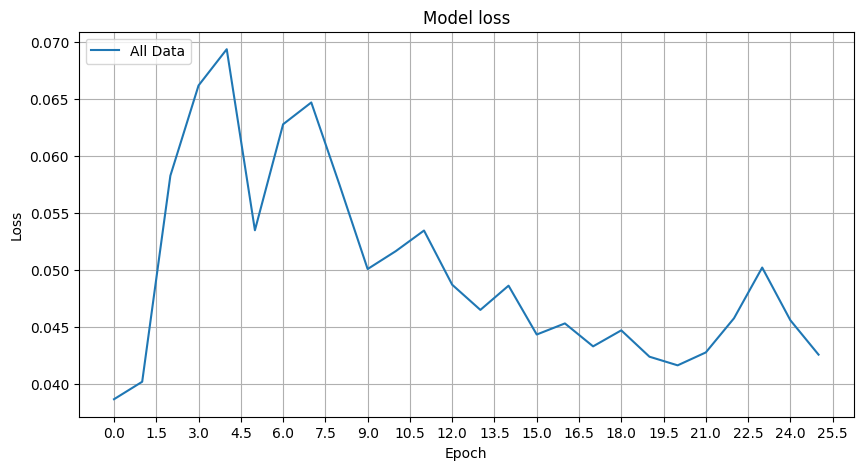

In [70]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(10, 5), sharex=True)
plt.plot(history_final.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(n_epochs))
plt.legend(["All Data"], loc="upper left")
plt.grid()
plt.show()

In [71]:
print("Save model and scaler")
modelName=f"{tune_folder}-{period_str}"
#modelName='test2022-20for10'
file_model=f'{model_path}/{modelName}_ma.h5'
file_scaler=f'{model_path}/scaler_{modelName}.gz'
file_scaler_pred=f'{model_path}/scaler_pred_{modelName}.gz'

model.save(file_model)

joblib.dump(scalerFinalTrain,file_scaler)
joblib.dump(scalerFinalPred ,file_scaler_pred)

Save model and scaler


['train_model/scaler_pred_Close_30To5_QQQ_E25S11-Y2020-2023.gz']